# Data preparation:

## Setting up:

In [1]:
# run script that installs missing libraries
! chmod 755 ../scripts.sh
! ../scripts.sh

  Using cached cf_units-3.0.1.post0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (491 kB)
  Using cached antlr4_python3_runtime-4.7.2-py3-none-any.whl
^C
ERROR: Operation cancelled by user


In [2]:
import os
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cf_units
from datetime import datetime
from datetime import timedelta
import rasterio
import cartopy.crs as ccrs
import gcsfs
from tqdm import tqdm
import pyproj
from pyproj import Transformer
from google.cloud import storage
from re import search
from os import listdir
from os.path import isfile, join
from scipy import ndimage


from process_pangeo import *
from GC_scripts import *
from processRCM import *
from reprojectionFunctions import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Google cloud
PROJECT = 'ee-iceshelf-gee4geo'
BUCKET = "ee-downscalingclimatemodels"

os.environ["GCLOUD_PROJECT"] = PROJECT
storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET)

In [4]:
def filesInDir(pathLocal):
    return sorted([f for f in listdir(pathLocal) if isfile(join(pathLocal, f))])

def empty_dir(pathLocal):
  # delete all files as precaution
  for file_name in os.listdir(pathLocal):
    # construct full file path
    file = pathLocal + file_name
    if os.path.isfile(file):
        os.remove(file)
        
def filesInDirWithVar(pathLocal, VAR):
    files = filesInDir(pathLocal)
    filesWithVar = []
    for f in files:
        if search(f'{VAR}_', f):
            filesWithVar.append(f)
    return filesWithVar

In [5]:
def plotAllVar(GCM_xy, m=3, n=3, name='GCM'):
    vars_ = list(GCM_xy.data_vars)
    coords = list(GCM_xy.coords)
    f = plt.figure(figsize=(20, 10))
    map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
    for i in range(len(vars_)):
        var = vars_[i]
        ax = plt.subplot(m, n, i + 1, projection=ccrs.SouthPolarStereo())
        GCM_xy[var].isel(time=0).plot(ax=ax, x='x', y='y',
                transform=ccrs.SouthPolarStereo(), add_colorbar=True)
        ax.coastlines('10m', color='black')
        ax.gridlines()
        ax.set_title(f'{GCM_xy[var].long_name} ({var})')
    plt.suptitle(f'First time step {GCM_xy.time[0].values} of {name}')

## Read data:

### Monthly GCM xy: 
GCM projected from lat/lon to polar stereographic coordinates. 

#### Vars GCM:

For precipitation conversion: 1 kg/m2/s = 86400 mm/day.
Pressure level: near surface --> 925 Hpa

- **pr**: precipitation [kg m-2 s-1] --> need to change to  [mmWE/day], eq: **RF**
- **psl**: sea level pressure [Pa] --> need to change to [hPa], eq: **SP**
- **rlut**: outgoing longwave radiation [W/m2], eq: **LWD**
- **rsut**: outgoing shortwave radiation [W/m2], eq: **SWD**
- rsdt: incident shortwave radiation [W/m2]
- **tas**: near surface air temp [K] --> need to change to [°C], eq: **TT**
- **uas**: eastward near surface wind [m/s], eq: **UUP** at surface pressure (PLEV:7)
- **vas**: northward near surface wind [m/s], eq: **VVP** at surface pressure (PLEV:7)


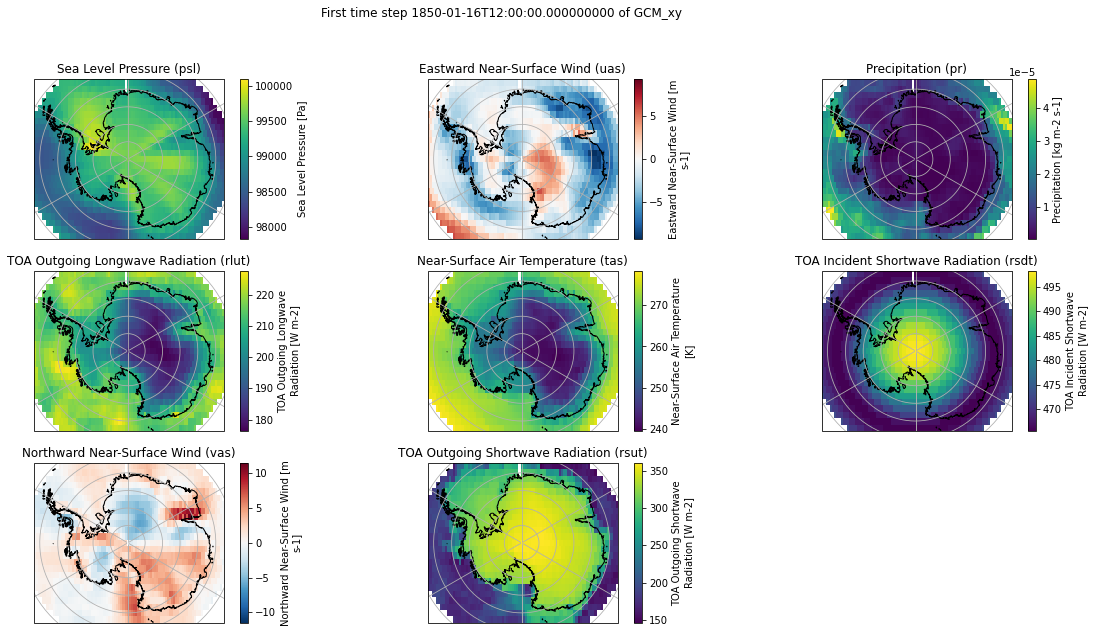

In [6]:
# open from google cloud
# open from google cloud
fileGC = 'ACCESS1-3-stereographic_monthly.nc'
# upload to GC:
print('Downloading from GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
downloadFileFromGC(pathGC, '', fileGC)

GCM_xy = xr.open_dataset(fileGC)
os.remove(fileGC)
GCM_xy_plot = GCM_xy.drop(['lat_bnds', 'lon_bnds', 'time_bnds','spatial_ref'])
plotAllVar(GCM_xy_plot, m=3, n=3, name='GCM_xy')

### RCM xy:
#### Vars RCM: 

PLEVLS: [200., 500., 600., 700., 800., 850., 925.]

ATMLAY: [0.99892 , 0.999325, 0.99973]

Atmosphere: 
- CC: Cloud Cover
- QQP: Specific Humidity [g/kg] (for 7 PLEV)
- RH: Relative Humidity [%] (ATMLAY: 3)

Water mass processes: 
- ME: Meltwater production [mmWE/day] (SECTOR1_1: 1)
- **RF**: Rainfall [mmWE/day] -> [mm/day]
- RU: Run-off of meltwater and rain water [mmWE/day] (SECTOR: 1)
- SF: Snowfall [mmWE/day]
- SMB: Surface Mass Balance (SMB~SF+RF-RU-SU-SW) [mmWE/day] (SECTOR: 1)
- SU: Sublimation and evaporation [mmWE/day] (SECTOR: 1)

Temperature: 
- **TT**: Temperature [°C] (ATMLAY:1, 0.9997)
- TTP: Temperature [°C] (PLEV: 7)

Pressure: 
- **SP**: Surface Pressure [hPa]

Radiation: 
- **SWD**: Short Wave Downward [W/m2]
- **LWD**: Long  Wave Downward [W/m2]

Wind speeds:
- **UUP**: x-Wind Speed component [m/s] (PLEV: 7)
- **VVP**: y-Wind Speed component [m/s] (PLEV: 7)

#### Winds, take last not nan value:

In [7]:
VAR = 'VVP'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
#vvp = ProcesasRCMVar(VAR, xr.open_dataset(fileGC))
DATASET = xr.open_dataset(fileGC).rename({'X':'x', 'Y':'y','TIME':'time'}).drop(['TIME_bnds', 'PLEV_bnds'])
os.remove(fileGC)

nbmonths = DATASET.dims['time']
x = DATASET.dims['x']
y = DATASET.dims['y']
nb_vars = len(list(DATASET.data_vars))
var_list = list(DATASET.data_vars)

print(f'Number of variables: {nb_vars}')
print(f'Variables: {var_list}')
    
#INPUT_2D=np.transpose(np.asarray([DATASET[i].values for i in var_list]),[1,3,2,0])
vvp=np.transpose(np.asarray(DATASET[VAR].values),[0,1, 2,3])
vvp.shape

Number of variables: 1
Variables: ['VVP']


(366, 7, 148, 176)

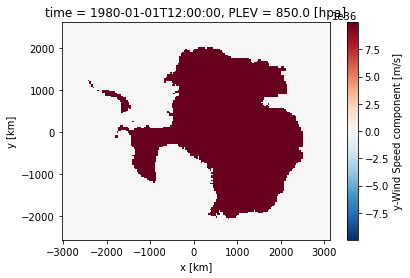

In [8]:
DATASET.isel(time=0, PLEV = 5).VVP.plot(x='x')

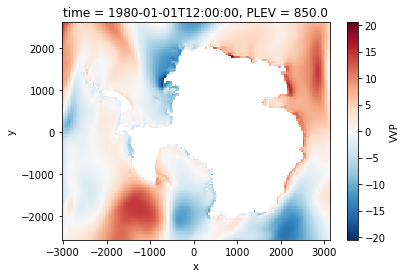

In [9]:
# Replace missing values with NaN
DATASET = xr.where(DATASET[VAR]<90, DATASET, np.nan)
DATASET.isel(time=0, PLEV = 5).VVP.plot(x='x')

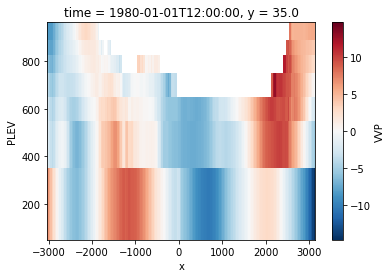

In [10]:
DATASET.sel(time=DATASET.time[0].values, y= 35).VVP.plot(x='x')

100%|██████████| 1/1 [00:19<00:00, 19.89s/it]


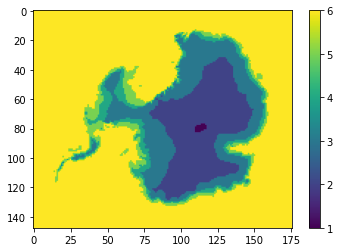

In [18]:
# TEST:
# time 0:

A, B = [], []

for j in tqdm(range(1)):
    time0 = DATASET.time[j].values
    a  = np.empty((DATASET.dims['y'],DATASET.dims['x']))
    b = np.empty((DATASET.dims['y'],DATASET.dims['x']))

    for rownmb in range(len(DATASET.y)):
        y0 = DATASET.y[rownmb].values
        d = pd.DataFrame(DATASET.sel(time=time0, y=y0).VVP.values)

        lastValIndex = []
        lastNoNanValue = []
        for colnmb in range(len(d.columns)):
            x0 = DATASET.x[colnmb].values
            lastInd = d[colnmb].last_valid_index()

            # append index value
            lastValIndex.append(lastInd)

            # append last value
            lastNoNanValue.append(DATASET.sel(y=y0, x=x0, time =time0).isel(PLEV=lastInd).VVP.values)

        a[rownmb,:] = lastValIndex
        b[rownmb,:] = lastNoNanValue
    A.append(a)
    B.append(b)
    
plt.imshow(a)
plt.colorbar()

In [19]:
np.asarray(B).shape

(1, 148, 176)

In [12]:
d = xr.Dataset(coords = DATASET.coords, attrs = DATASET.attrs)
d['VVP'] = xr.Variable(dims = ('time','y','x'), 
                                data = B, 
                                attrs = DATASET['VVP'].attrs)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/variable.py:229: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.asarray(data)


ValueError: dimensions ('time', 'y', 'x') must have the same length as the number of data dimensions, ndim=32

#### One time step:

In [ ]:
# Select variables that are also in GCM: 

# precipitation: 
VAR = 'RF'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
rf = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

# sea level pressure: 
VAR = 'SP'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
sp = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

# radiations:
VAR = 'SWD'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
swd = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

VAR = 'LWD'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
lwd = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

# near surface air temp:
VAR = 'TT'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
tt = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

# wind at surface level (PLEV:0)
VAR = 'UUP'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
uup = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

VAR = 'VVP'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
vvp = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)


# precipitation: 
VAR = 'SMB'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
smb = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

# Put together all variables:
RCMxy = xr.merge([rf, sp, swd, lwd, tt, uup, vvp, smb])

# Basic pre-processing
RCMxy = BasicPreprocRCM(RCMxy)

plotAllVar(RCMxy, m=3, n=3, name='RCMxy')

## Preprocessing: 

### RCM 
#### Resample to monthly freq and save:

In [ ]:
#vars_ = ['RF', 'SP', 'LWD', 'SWD', 'TT', 'UUP', 'VVP', 'SMB']
vars_= ['SMB']
! rm -r ../../data/tmp/*

download = True
if download:
    for VAR in vars_:
        print(f'{VAR}:\n--------------')
        pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/{VAR}/'
        pathLocal = '../../data/tmp/'
        filesGC = listFilesGC(pathGC, VAR)

        #------ Download files from GC
        print('Downloading files from GC')
        downloadFilesFromGC(pathGC, pathLocal, filesGC)

        onlyfiles = filesInDirWithVar(pathLocal, VAR)
        print('Examples of files: \n {}'.format(onlyfiles[0]))

        #------ concatenate all years of a variable
        # first year
        if len(onlyfiles) == 121:
            print('Concatenating...')
            f0 = onlyfiles[0]
            df0 = xr.open_dataset(pathLocal+f0)
            # preprocessing and resampling
            df0 = resampleMonthlyMean(BasicPreprocRCM(ProcessRCMVar(VAR, df0)))

            for f in onlyfiles[1:]:
                df = xr.open_dataset(pathLocal+f)
                # preprocessing and resampling
                df = resampleMonthlyMean(BasicPreprocRCM(ProcessRCMVar(VAR, df)))

                # concatenate with previous years
                df0 = xr.concat([df0,df], dim = 'time')

            # save file locally:
            path = '../../data/toGC/'
            name = f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_monthly.nc'
            df0.to_netcdf(name)

            # upload to GC:
            print('Uploading to GC...')
            pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
            uploadFileToGC(pathGC, name)

            # delete file and temporary directory:
            os.remove(name)
            ! rm ../../data/tmp/*

        else:
            print(f'Error: len only files is:{len(onlyfiles)}')
            break
            
    # test:
    f = plt.figure(figsize=(10, 10))
    map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
    ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
    df0.isel(time = 1).VVP.plot(ax=ax, x='x', y='y',transform=ccrs.SouthPolarStereo())
    ax.coastlines('10m', color='white')
    ax.gridlines()

#### Concatenate all variables:

In [ ]:
vars_ = ['RF', 'SP', 'LWD', 'SWD', 'TT', 'UUP', 'VVP', 'SMB']
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
pathLocal = '../../data/tmp/'

download == True
if download:
    # names of files on GC
    filesGC = [f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_monthly.nc' for VAR in vars_]

    # download files and store locally
    downloadFilesFromGC(pathGC, pathLocal, filesGC)

    # concatenate and save nc file to GC
    f0 = filesGC[0]
    df0 = xr.open_dataset(pathLocal+f0)

    for f1 in filesGC[1:]:
        df1 = xr.open_dataset(pathLocal+f1)
        df0 = xr.merge([df0,df1])

    # save file locally:
    name = f'MAR(ACCESS1-3)_monthly.nc'
    df0.to_netcdf(name)

    # upload to GC:
    print('Uploading to GC...')
    pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
    uploadFileToGC(pathGC, name)

    # delete file and temporary directory:
    os.remove(name)
    ! rm ../../data/tmp/*

    # test:
    plotAllVar(df0, m=3, n=3, name='RCM_xy')

#### (Closer look at winds):

In [ ]:
VAR = 'VVP'
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/{VAR}/'
fileGC = f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_day_19800101-19801231.nc'
vvplevels = xr.open_dataset(fileGC)
vvplevels = vvplevels.rename({'X':'x', 'Y':'y','TIME':'time'})

lower = vvplevels.where(vvplevels.VVP<90)
upper = vvplevels.where(vvplevels.VVP>90)

for i in range(2):
    vvplevels[f'VVP_plvl_{i+1}'] = vvplevels.VVP.isel(PLEV=i)

for level in [2, 3,4,5,6]:
    vvplevels[f'VVP_plvl_{level+1}_lower'] = lower.VVP.isel(PLEV=level)
    vvplevels[f'VVP_plvl_{level+1}_upper'] = upper.VVP.isel(PLEV=level)

vvplevels = vvplevels.drop(['VVP','TIME_bnds','PLEV_bnds'])
vvplevels = KmtoM(vvplevels)

vars_ = list(vvplevels.data_vars)
coords = list(vvplevels.coords)
f = plt.figure(figsize=(20, 10))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
for i in range(len(vars_)):
    var = vars_[i]
    ax = plt.subplot(3, 4, i + 1, projection=ccrs.SouthPolarStereo())
    vvplevels[var].isel(time=0).plot(ax=ax, x='x', y='y',
            transform=ccrs.SouthPolarStereo(), add_colorbar=True)
    ax.coastlines('10m', color='black')
    ax.gridlines()
    ax.set_title(f'{var}')
plt.suptitle(f'First time step of {vvplevels[var].long_name}')

In [ ]:
VAR = 'UUP'
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/{VAR}/'
fileGC = f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_day_19800101-19801231.nc'
vvplevels = xr.open_dataset(fileGC)
vvplevels = vvplevels.rename({'X':'x', 'Y':'y','TIME':'time'})

lower = vvplevels.where(vvplevels[VAR]<90)
upper = vvplevels.where(vvplevels[VAR]>90)

for i in range(2):
    vvplevels[f'VVP_plvl_{i+1}'] = vvplevels[VAR].isel(PLEV=i)

for level in [2, 3,4,5,6]:
    vvplevels[f'{VAR}_plvl_{level+1}_lower'] = lower[VAR].isel(PLEV=level)
    vvplevels[f'{VAR}_plvl_{level+1}_upper'] = upper[VAR].isel(PLEV=level)

vvplevels = vvplevels.drop([VAR,'TIME_bnds','PLEV_bnds'])
vvplevels = KmtoM(vvplevels)

vars_ = list(vvplevels.data_vars)
coords = list(vvplevels.coords)
f = plt.figure(figsize=(20, 10))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
for i in range(len(vars_)):
    var = vars_[i]
    ax = plt.subplot(3, 4, i + 1, projection=ccrs.SouthPolarStereo())
    vvplevels[var].isel(time=0).plot(ax=ax, x='x', y='y',
            transform=ccrs.SouthPolarStereo(), add_colorbar=True)
    ax.coastlines('10m', color='black')
    ax.gridlines()
    ax.set_title(f'{var}')
plt.suptitle(f'First time step of {vvplevels[var].long_name}')

### GCM:
So that is similar to RCM

In [ ]:
# open from google cloud
fileGC = 'ACCESS1-3-stereographic_monthly.nc'
# upload to GC:
print('Downloading from GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
downloadFileFromGC(pathGC, '', fileGC)

GCM_xy = xr.open_dataset(fileGC)
os.remove(fileGC)

GCM_xy = GCM_xy.rio.write_crs("epsg:3031")
GCM_xy.attrs['crs'] = 3031

# Slice to same time as RCM:
Firstdate = datetime(1980,1,16, 12, 0,0)
Enddate = datetime(2100,12,16, 12, 0,0)

GCM_xy = GCM_xy.sel(time = slice(Firstdate, Enddate))
GCM_xy = GCM_xy.drop(['lat_bnds', 'lon_bnds', 'time_bnds','rsdt'])

# change prec to right units (mmWE/day): 
var = 'pr'
GCM_xy[var] = xr.Variable(dims = GCM_xy[var].dims, 
                            data = GCM_xy[var]*86400, 
                            attrs = RCMxy.RF.attrs)

# change pressure from pa to hpa: 1pa = 0.01 hPa 
var = 'psl'
GCM_xy[var] = xr.Variable(dims = GCM_xy[var].dims, 
                            data = GCM_xy[var]*0.01, 
                            attrs = RCMxy.SP.attrs)

# change temperature from K to C: 1K = -272,15 °C 
var = 'tas'
GCM_xy[var] = xr.Variable(dims = GCM_xy[var].dims, 
                            data = GCM_xy[var]-272.15, 
                            attrs = RCMxy.TT.attrs)
# resample so that months start on same date as RCM
GCM_xy = resampleMonthlyMean(GCM_xy)

GCM_xy

In [ ]:
# Save file
name = 'ACCESS1-3-stereographic_monthly_cleaned.nc'

# save file locally:
GCM_xy.attrs['crs'] = 3031
GCM_xy.to_netcdf(name)

# upload to GC:
print('Uploading to GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
uploadFileToGC(pathGC, name)
os.remove(name)

In [ ]:
plotAllVar(GCM_xy, m=3, n=3, name='GCM_xy')

## GCM like RCM
Reproject RCM xy on GCM xy grid: Creates fake GCM like outputs from RCM

In [ ]:
def MovingAverageFilter(df):
    Smoothed = xr.Dataset(coords = df.coords, attrs = df.attrs)
    vars_ = list(df.data_vars)
    for var in vars_:
        smoothed = ndimage.uniform_filter(df[var].values, size=3)
        Smoothed[var] = xr.Variable(dims = df[var].dims, 
                                data = smoothed, 
                                attrs = df[var].attrs)
        
    return Smoothed

In [ ]:
# RCM xy:
# open from google cloud
fileGC = f'MAR(ACCESS1-3)_monthly.nc'
# upload to GC:
print('Downloading from GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
downloadFileFromGC(pathGC, '', fileGC)

RCM_xy = xr.open_dataset(fileGC)
os.remove(fileGC)
RCM_xy

In [ ]:
# Compare resolutions
print("GCM with crs x/y:\n----------------\n")
print_raster(GCM_xy.tas)
print("RCM with crs x/y:\n----------------\n")
print_raster(RCM_xy.TT)

In [ ]:
# Reproject
vars_ = list(RCM_xy.keys())
GCM_like = xr.Dataset()
dim = ('time', 'y', 'x')
for var in vars_:
    GCM_like[var] = xr.Variable(dims = dim, 
                                data = RCM_xy[var].rio.reproject_match(GCM_xy.tas), 
                                attrs = RCM_xy[var].attrs)
GCM_like = GCM_like.assign_coords(RCM_xy[var].rio.reproject_match(GCM_xy.tas).coords)

# Smooth with moving average:
GCM_like_smoothed = MovingAverageFilter(GCM_like)
GCM_like_smoothed

In [ ]:
# Save file
fileGC = 'MAR(ACCESS1-3)-stereographic_monthly_GCM_like.nc'

# save file locally:
GCM_like_smoothed.attrs['crs'] = 3031
GCM_like_smoothed.to_netcdf(fileGC)

# upload to GC:
print('Uploading to GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
uploadFileToGC(pathGC, fileGC)
os.remove(fileGC)

In [ ]:
# Read GCM like RCM:
fileGC = 'MAR(ACCESS1-3)-stereographic_monthly_GCM_like.nc'
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
downloadFileFromGC(pathGC, '', fileGC)

GCMLike = xr.open_dataset(fileGC)
os.remove(fileGC)
GCMLike

In [ ]:
print("GCM_like with crs x/y:\n----------------\n")
print_raster(GCM_like_smoothed)

In [ ]:
plotAllVar(GCM_like, m=3, n=3, name='GCM like RCM')

In [ ]:
plotAllVar(GCM_like_smoothed, m=3, n=3, name='GCM smoothed like RCM')

In [ ]:
plotAllVar(RCM_xy, m=3, n=3, name='RCM_xy')

In [ ]:
plotAllVar(GCM_xy, m=3, n=3, name='GCM_xy')